In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
class visualize_environment():
    # given any number of environment states this class will record them and play them sequentially as a movie
    
    def __init__(self):
        # load all images and assign to self
        self.tall_grass = Image.open("textures/grass.png").convert("RGBA")
        self.grass = Image.open("textures/cut_grass.png").convert("RGBA")
        self.wood = Image.open("textures/wood.png").convert("RGBA")
        self.pavement = Image.open("textures/pavement.png").convert("RGBA")
        self.agent = Image.open("textures/agent.png").convert("RGBA")
        self.entry = Image.open("textures/entry.png").convert("RGBA")             # default east
        self.exit = Image.open("textures/exit.png").convert("RGBA")               # default east
        self.tile_shape = (32, 32, 4) # shape of all tiles after conversion to np array
        self.environment_history = []
        
    def display_new_environment_state(self, environment_state):
        plt.figure(figsize=(20,20))
        plt.imshow(self.__get_environment_state_image_array(environment_state))
        plt.xticks([])
        plt.yticks([])
        plt.show()
        
    def recive_environment_state(self, environment_state):
        # records the environment state
        
        environment_state_image_array = self.__get_environment_state_image_array(environment_state)
        self.environment_history.append(environment_state_image_array)
    
    def output_history(self):
        # produces an mp4 file of the mower mowing the lawn over time.
        
        return None
        
    def __get_environment_state_image_array(self, environment_state):
        # returns image of the environment state as a 3d numpy array
        
        # save env dimensions
        ncols = environment_state.shape[1]
        nrows = environment_state.shape[0]
        environment_state_image_as_array = []
        for tile_id in environment_state.flatten():
            environment_state_image_as_array.append(self.__get_tile(tile_id))
        environment_state_image_as_array = np.array(environment_state_image_as_array)
        # convert array shape to (height*nrows, width*ncols, intensity)
        height, width, intensity = self.tile_shape
        return environment_state_image_as_array.reshape(nrows, ncols, height, width, intensity).swapaxes(1,2).reshape(height*nrows, width*ncols, intensity)
        
    def __construct_tile(self, background, foreground, foreground_rotation_angle):
        # rotates foreground by foreground_rotation_angle (which should be divisible by 90)
        # then places the foreground image in the center of backround image
        foreground = foreground.rotate(foreground_rotation_angle)
        background.paste(foreground, (0, 0), foreground)
        return background
        
    def __get_tile(self, tile_id):
        # returns the tile matching the id as a 3D numpy array
        
        # a tile_id is a STRING of three numbers where:
            # digit 1: (background_id) the background tile (ex. grass, wood, pavement)
            # digit 2: (entry_id) the direction of entry onto the tile
            # digit 3: (exit_id) the direction of exit from the tile
        # background_id's:
            # agent can occupy:
                # 1 = grass      (mowed lawn)
                # 2 = pavement   (a space that can be occupied but not mowed)
            # agent cannot occupy:
                # 8 = tall_grass (mowable lawn)
                # 9 = wood       (a space the mower cannot occupy)
        # entry_id's:
            # 0 = no overlay
            # 1 = north
            # 2 = south
            # 3 = east
            # 4 = west
        # exit_id's:
            # 0 = agent
            # 1 = north
            # 2 = south
            # 3 = east
            # 4 = west
        # the easiest way to explain this is by example,
            # tile_id = 200 is a gravel tile (background_id = 2) with nothing overlaid on top (entry_id = 0), exit_id is not checked because there is no overlay
            # tile_id = 240 is a gravel tile (background_id = 2) with an arrow pointing west (entry_id = 4) to west (exit_id = 4)
            # tile_id = 132 is a grass tile (background_id = 1) with an arrow that points east (entry_id = 3) to south (exit_id = 2)
        # THIS FORMAT HAS ONE EXCEPTION (the agent):
            # tile_id = 130 is a grass tile (background_id = 1) with an arrow pointing east (entry_id = 3) that's converted to the agent pointing in the same direction (exit_id = 0)
            # tiles containing the agent are the only tiles where the exit_id does not represent the direction of exit (because the agent hasn't exited yet)

        # check id for validity
        if (not isinstance(tile_id, str)) or (len(tile_id) != 3):
            raise Exception('invalid tile_id ' + tile_id)
        # extract all parts of the tile id
        background_id = tile_id[0] # id of the backround tile
        entry_id = tile_id[1] # id of entry direction
        exit_id = tile_id[2] # id of exit direction
        # define or return background image
        if background_id == '1':
            tile = copy.copy(self.grass) # if I don't create a copy and instead create a pointer the image operations will modiy self.grass
        elif background_id == '2':
            tile = copy.copy(self.pavement)
        elif background_id == '8': # return id's 8 & 9 immediately because they shouldn't ever have an overlay
            return np.asarray(self.tall_grass)
        elif background_id == '9':
            return np.asarray(self.wood)
        else:
            raise Exception('invalid background_id ' + background_id)
            
        # overlay entry image
        overlay = self.entry if exit_id != '0' else self.agent # define image to be overlaid
        if entry_id == '0': # if there is no foreground image return existing tile
            return np.asarray(tile)
        elif entry_id == '1': # entry = north
            tile = self.__construct_tile(tile, overlay, 270)
        elif entry_id == '2': # entry = south
            tile = self.__construct_tile(tile, overlay, 90)
        elif entry_id == '3': # entry = east
            tile = self.__construct_tile(tile, overlay, 180)
        elif entry_id == '4': # entry = west
            tile = self.__construct_tile(tile, overlay, 0)
        else:
            raise Exception('invalid entry_id ' + entry_id)
        # overlay exit image
        if exit_id == '0': # the agent is on the current tile, it should have already been overlaid so return it
            return np.asarray(tile)
        elif exit_id == '1': # exit = north
            return np.asarray(self.__construct_tile(tile, self.exit, 90))
        elif exit_id == '2': # exit = south
            return np.asarray(self.__construct_tile(tile, self.exit, 270))
        elif exit_id == '3': # exit = east
            return np.asarray(self.__construct_tile(tile, self.exit, 0))
        elif exit_id == '4': # exit = west
            return np.asarray(self.__construct_tile(tile, self.exit, 180))
        else:
            raise Exception('invalid exit_id ' + exit_id)
        

In [3]:
environment = np.array([
    ['900','900','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800', '800', '800', '800'],
    ['800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800', '800', '800', '800'],
    ['800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800', '800', '800', '800'],
    ['800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800', '800', '800', '800'],
    ['800','800','800','800','800','800','800','800','800','800','900','900','900','800','800','800','800','800','800', '800', '800', '800'],
    ['800','800','800','800','800','800','800','800','800','800','900','900','900','800','800','800','800','800','800', '800', '800', '800'],
    ['800','800','800','800','200','200','200','200','900','900','900','900','900','900','900','900','800','800','800', '800', '800', '800'],
    ['800','800','800','800','200','200','200','200','900','900','900','900','900','900','900','900','800','800','800', '800', '800', '800'],
    ['800','800','800','800','200','200','800','800','800','800','800','800','900','900','900','900','800','800','800', '800', '800', '800'],
    ['800','800','800','800','200','200','800','800','800','800','800','800','900','900','900','900','800','800','800', '800', '800', '800'],
    ['800','800','800','800','200','200','800','800','800','800','800','800','800','800','800','800','800','800','800', '800', '800', '800'],
    ['800','800','800','800','200','200','800','800','800','800','800','800','800','800','800','800','800','800','800', '800', '800', '800'],
    ['200','200','200','200','200','200','800','800','800','800','900','900','800','800','800','800','800','800','900', '900', '800', '800'],
    ['200','200','200','200','200','200','800','800','800','800','900','900','800','800','800','800','800','800','900', '900', '800', '800'],
    ['800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800', '800', '800', '800'],
    ['800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800', '800', '800', '800']])

In [3]:
environment_for_visualization_testing = np.array([
    ['900','900','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800', '800', '800', '800'],
    ['800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800', '800', '800', '800'],
    ['800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800', '800', '800', '800'],
    ['800','800','800','123','143','142','800','800','800','800','800','800','800','800','800','800','800','800','800', '800', '800', '800'],
    ['800','123','143','141','800','140','800','800','800','800','900','900','900','800','800','800','800','800','800', '800', '800', '800'],
    ['800','121','800','800','800','800','800','800','800','800','900','900','900','800','800','800','800','800','800', '800', '800', '800'],
    ['800','121','800','800','200','200','200','200','900','900','900','900','900','900','900','900','800','800','800', '800', '800', '800'],
    ['800','131','124','800','200','200','200','200','900','900','900','900','900','900','900','900','800','800','800', '800', '800', '800'],
    ['800','800','121','800','200','200','800','112','800','800','800','800','900','900','900','900','800','800','800', '800', '800', '800'],
    ['800','800','121','800','200','200','800','112','800','800','800','800','900','900','900','900','800','800','800', '800', '800', '800'],
    ['800','800','131','134','234','234','134','114','800','800','800','800','800','800','800','800','800','800','800', '800', '800', '800'],
    ['800','800','800','800','200','200','800','800','800','800','800','800','800','800','800','800','800','800','800', '800', '800', '800'],
    ['200','200','200','200','200','200','800','800','800','800','900','900','800','800','800','800','800','800','900', '900', '800', '800'],
    ['200','200','200','200','200','200','800','800','800','800','900','900','800','800','800','800','800','800','900', '900', '800', '800'],
    ['800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800', '800', '800', '800'],
    ['800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800','800', '800', '800', '800']])

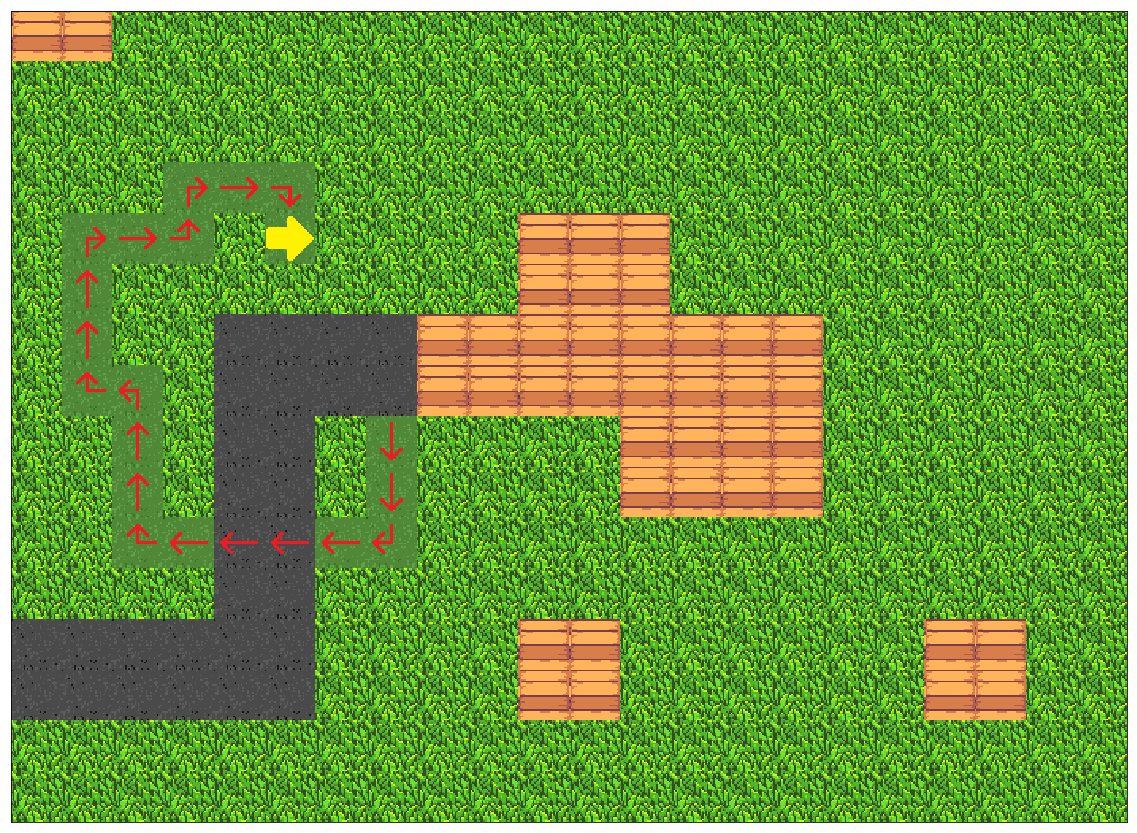

In [6]:
visualize_environment().display_environment_state(environment_for_visualization_testing)

In [6]:
def generate_blank_environment(nrows, ncols):
    # returns environment state of shape (nrows, ncols) full of tall_grass
    environment_state = []
    for row in range(nrows):
        environment_state.append(np.full(ncols, '800'))
    return np.array(environment_state)

# generate_blank_environment(16,22)